In [54]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
imiii
import matplotlib.pyplot as plt
import torchnet as tnt
import random
import copy
import numpy as np
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import multi_dot
from scipy.sparse.linalg import cg
import faiss
from IPython.display import display
%config InlineBackend.figure_format = 'retina'
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'
from sift import SIFT
import cv2 as cv2
from skimage import feature
Labels = "/data02/Atin/mean-teacher/pytorch/data-local/labels/cifar10/250_balanced_labels/00.txt"

In [2]:
class Normalize(nn.Module):

    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power
    
    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1./self.power)
        out = x.div(norm)
        return out
    
def sem_sup_feature(conv_model, dl):
    semi_supervised_feature_list = []
    label_list = []
    for b in dl:
        data, label = b
        data = data.cuda()
        with torch.no_grad():
            out = conv_model(data)
            b_size = out
            semi_supervised_feature_list.append(out)
            label_list.append(label)
    final_list = torch.cat(semi_supervised_feature_list, dim=0)
    final_label_list = torch.cat(label_list, dim=0)
    return final_list, final_label_list

def return_train_labels_index(Labels_loc):
    label_list = []
    with open(Labels, 'r') as df:
        for l in df.readlines():
            label_list.append(int((l.split("_")[0])))
#             print(l)
#             label_list.append(int(l.split("_")[0]))
                
    return np.array(label_list)

def buildGraph_new(MatX, kernel_type, rbf_sigma=None, knn_num_neighbors=None, gamma=3, dim=128):
    num_samples = MatX.shape[0]
    affinity_matrix = np.zeros((num_samples, num_samples), np.float32)
    if kernel_type == 'rbf':
        if rbf_sigma == None:
            raise ValueError('You should input a sigma of rbf kernel!')
        for i in range(num_samples):
            row_sum = 0.0
            for j in range(num_samples):
                diff = MatX[i, :] - MatX[j, :]
                affinity_matrix[i][j] = np.exp(sum(diff ** 2) / (-2.0 * rbf_sigma ** 2))
                row_sum += affinity_matrix[i][j]
            affinity_matrix[i][:] /= row_sum
    elif kernel_type == 'knn':
        if knn_num_neighbors == None:
            raise ValueError('You should input a k of knn kernel!')
        
#         index = faiss.IndexFlatL2(192*8*8)
        index = faiss.IndexFlatIP(dim)
        

        index.add(MatX)
        distances, indices = index.search(MatX, knn_num_neighbors)
        
#         nbrs = NearestNeighbors(n_neighbors=knn_num_neighbors, algorithm='auto', leaf_size=100, metric='euclidean').fit(MatX)
        # distances, indices = nbrs.kneighbors(MatX)
        # trns = lambda x: 0 if x < 0 else x
#         trns = lambda x: np.exp(x ** 2 /  (-2.0 * rbf_sigma ** 2))
#         trns = np.vectorize(trns)
        
        trns = lambda x: 0 if x < 0 else x**gamma
        trns = np.vectorize(trns)
        
        for i in range(num_samples):
#             distances, indices = nbrs.kneighbors(MatX[[i]])
            k_neighbors = indices[i]
            k_nb_distances = distances[i]
            # k_nb_affinity = 1 - k_nb_distances
            k_nb_affinity = trns(k_nb_distances)
            affinity_matrix[i][k_neighbors] = k_nb_affinity
            affinity_matrix[i,i] = 0.0
#             if i%100 ==0:
#                 print(i)
    else:
        raise NameError('Not support kernel type! You can use knn or rbf!')

    return (affinity_matrix + affinity_matrix.T)/2

def labelPropagation_new(affinity_matrix, Mat_Label, Mat_Unlabel, labels, alpha=.1):
    # initialize
    num_label_samples = Mat_Label.shape[0]
    num_unlabel_samples = Mat_Unlabel.shape[0]
    num_samples = num_label_samples + num_unlabel_samples
    labels_list = np.unique(labels)
    num_classes = len(labels_list)

    # MatX = np.vstack((Mat_Label, Mat_Unlabel))
    clamp_data_label = np.zeros((num_label_samples, num_classes), np.float32)
    for i in range(num_label_samples):
        clamp_data_label[i][labels[i]] = 1.0

    label_function = np.zeros((num_samples, num_classes), np.float32)
    label_function[0: num_label_samples] = clamp_data_label
    label_function[num_label_samples: num_samples] = 0

    # graph construction
    # affinity_matrix = buildGraph_new(MatX, kernel_type, rbf_sigma, knn_num_neighbors)

    degree_vec = np.sum(affinity_matrix, axis=1)
    degree_vec_to_the_power_minus_half = 1/np.sqrt(degree_vec)
    degree_matrix_2_the_power_minus_half = np.diag(degree_vec_to_the_power_minus_half)
    d_minus_half_w_d_minus_half = multi_dot([degree_matrix_2_the_power_minus_half, affinity_matrix, degree_matrix_2_the_power_minus_half])

    dense_matrix = np.eye(num_samples) - alpha * d_minus_half_w_d_minus_half
    solution_list = []
    for i in range(num_classes):
        print(i)
        converged_solution = cg(dense_matrix, label_function[:,i])[0]
        converged_solution = np.reshape(converged_solution, (-1,1))
        solution_list.append(converged_solution)
    label_function = np.hstack(solution_list)

    unlabel_data_labels = np.zeros(num_unlabel_samples)
    for i in range(num_unlabel_samples):
        unlabel_data_labels[i] = np.argmax(label_function[i + num_label_samples])

    return unlabel_data_labels

In [30]:
hog_feature.reshape(1, -1).shape

(1, 324)

In [32]:
def sem_sup_feature(conv_model, dl):
    semi_supervised_feature_list = []
    label_list = []
    for b in dl:
        data, label = b
        data = data.cuda()
        with torch.no_grad():
            out = conv_model(data)
            b_size = out
            semi_supervised_feature_list.append(out)
            label_list.append(label)
    final_list = torch.cat(semi_supervised_feature_list, dim=0)
    final_label_list = torch.cat(label_list, dim=0)
    return final_list, final_label_list

def return_train_labels_index(Labels_loc):
    label_list = []
    with open(Labels, 'r') as df:
        for l in df.readlines():
            label_list.append(int((l.split("_")[0])))
#             print(l)
#             label_list.append(int(l.split("_")[0]))
                
    return np.array(label_list)

def pixel_feature(dl, type="pixel"):
    feature_list = []
    label_list = []
    for b in dl:
        data, label = b
        batch_size = data.size(0)
        if type == "pixel":
            out = data.view(batch_size, -1)
            feature_list.append(out)
        if type == "HOG":
            tr_data = data.numpy().transpose((0,2,3,1))
            for d in tr_data:
                img_resized = cv2.resize(d, (128,128))
                hog_feature, img_hog = feature.hog(img_resized, orientations=9, pixels_per_cell=(32,32), 
                                                   cells_per_block=(3, 3), transform_sqrt=True, block_norm="L1", visualize=True)
                feature_list.append(hog_feature.reshape(1,-1))
        if type == "SIFT":
            pass
            
        
        label_list.append(label)
        
    final_list = np.concatenate(feature_list)
    final_label_list = np.concatenate(label_list)
    return final_list, final_label_list

def return_train_labels_index(Labels_loc):
    label_list = []
    with open(Labels, 'r') as df:
        for l in df.readlines():
            a = l.rstrip().split("_")
            label_list.append(int(a[0]))
            
#             print(a)
#             print(type(a))
#             print(l.rstrip().split("_")[0])
#             label_list.append(int(l.rstrip().split("_")[0]))
                
    return np.array(label_list)

In [6]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='/data02/Atin/CIFAR10/', train=False,
                                           download=True, transform=transform_test)
trainset = torchvision.datasets.CIFAR10(root='/data02/Atin/CIFAR10/', train=True,
                                            download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                         shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Pixel feature

In [10]:
feature_mat_train_pixel, label_train_pixel = pixel_feature(trainloader)
feature_mat_test_pixel, label_test_pixel = pixel_feature(testloader)
whole_mat_pixel = np.concatenate((feature_mat_train_pixel, feature_mat_test_pixel))
whole_label_pixel = np.concatenate((label_train_pixel, label_test_pixel))

In [9]:
feature_mat_train.shape, label_train.shape

((50000, 3072), (50000,))

In [15]:
train_label_index_lp = return_train_labels_index(Labels)
unlabel_index_lp = list(set(range(60000)) - set(train_label_index_lp))

Mat_Label = feature_mat_train_pixel[train_label_index_lp] #Labelled data matrix
labels = label_train_pixel[train_label_index_lp] #Corresponding labels of Labelled data matrix
Mat_Unlabel = whole_mat[unlabel_index_lp] #UnLabelled data matrix
rest_label = whole_label[unlabel_index_lp]

In [18]:
Mat_Unlabel1 = Mat_Unlabel[:10000] #UnLabelled data matrix
rest_label1 = rest_label[:10000]
# Mat_Unlabel1 = Mat_Unlabel
# rest_label1 = rest_label
MatX = np.vstack((Mat_Label, Mat_Unlabel1))
MatX = MatX / np.linalg.norm(MatX, axis=-1)[:, np.newaxis]
affinity_matrix = buildGraph_new(MatX, "knn", None, 20, 1, dim = 3072)

KeyboardInterrupt: 

In [ ]:
unlabel_data_labels = labelPropagation_new(affinity_matrix, Mat_Label, Mat_Unlabel1, labels, alpha=.95)

In [ ]:
#HOG feature

In [59]:
# feature_mat_train, label_train = pixel_feature(trainloader, type="HOG")
# feature_mat_test, label_test = pixel_feature(testloader, type="HOG")
feature_mat_train, label_train = pixel_feature(trainloader)
feature_mat_test, label_test = pixel_feature(testloader)
whole_mat = np.concatenate((feature_mat_train, feature_mat_test))
whole_label = np.concatenate((label_train, label_test))

In [60]:
train_label_index_lp = return_train_labels_index(Labels)
unlabel_index_lp = list(set(range(60000)) - set(train_label_index_lp))

Mat_Label = feature_mat_train[train_label_index_lp] #Labelled data matrix
labels = label_train[train_label_index_lp] #Corresponding labels of Labelled data matrix
Mat_Unlabel = whole_mat[unlabel_index_lp] #UnLabelled data matrix
rest_label = whole_label[unlabel_index_lp]

In [61]:
Mat_Unlabel1 = Mat_Unlabel[:10000] #UnLabelled data matrix
rest_label1 = rest_label[:10000]
# Mat_Unlabel1 = Mat_Unlabel
# rest_label1 = rest_label
MatX = np.vstack((Mat_Label, Mat_Unlabel1))
MatX = MatX / np.linalg.norm(MatX, axis=-1)[:, np.newaxis]

# affinity_matrix = buildGraph_new(np.float32(MatX), "knn", None, 20, 1, dim = 324)
affinity_matrix = buildGraph_new(np.float32(MatX), "knn", None, 20, 1, dim = 3072)

In [ ]:
alpha_list = [0,.2, .4, .6, .8, .9, .95, 1]
accuracy_for_each_alpha_list = []
for alph in alpha_list:
    unlabel_data_labels = labelPropagation_new(affinity_matrix, Mat_Label, Mat_Unlabel1, labels, alpha=alph)
    corrects = 0
    for i in range(len(unlabel_data_labels)):
        if unlabel_data_labels[i] == rest_label1[i]:
            corrects +=1
    print("Accuracy for {} is {}".format(alph, corrects/10000))
    accuracy_for_each_alpha_list.append(corrects/10000)
plt.plot(alpha_list, accuracy_for_each_alpha_list, marker = 'o')
plt.title("accuracy vs alpha")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.show()

In [68]:
accuracy_for_each_alpha_list

[0.1007, 0.2529, 0.2552, 0.2575, 0.2617, 0.2616, 0.2594, 0.0935]

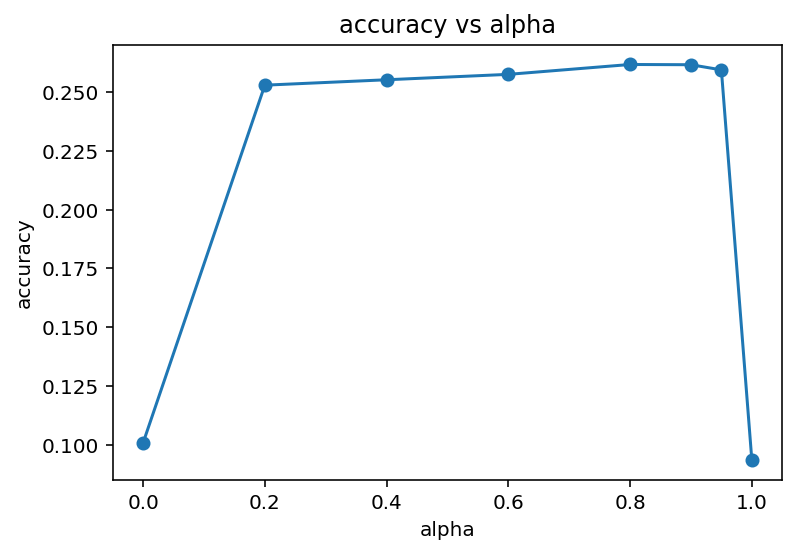

In [67]:
plt.plot(alpha_list, accuracy_for_each_alpha_list, marker = 'o')
plt.title("accuracy vs alpha")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.show()

0
1
2
3
4
5
6
7
8
9
Accuracy for 0 is 0.1007
0
1
2
3
4
5
6
7
8
9
Accuracy for 0.2 is 0.3435
0
1
2
3
4
5
6
7
8
9
Accuracy for 0.4 is 0.3499
0
1
2
3
4
5
6
7
8
9
Accuracy for 0.6 is 0.3575
0
1
2
3
4
5
6
7
8
9
Accuracy for 0.8 is 0.3609
0
1
2
3
4
5
6
7
8
9
Accuracy for 0.9 is 0.3554
0
1
2
3
4
5
6
7
8
9
Accuracy for 0.95 is 0.3398
0
1
2
3
4
5
6
7
8
9
Accuracy for 1 is 0.1035


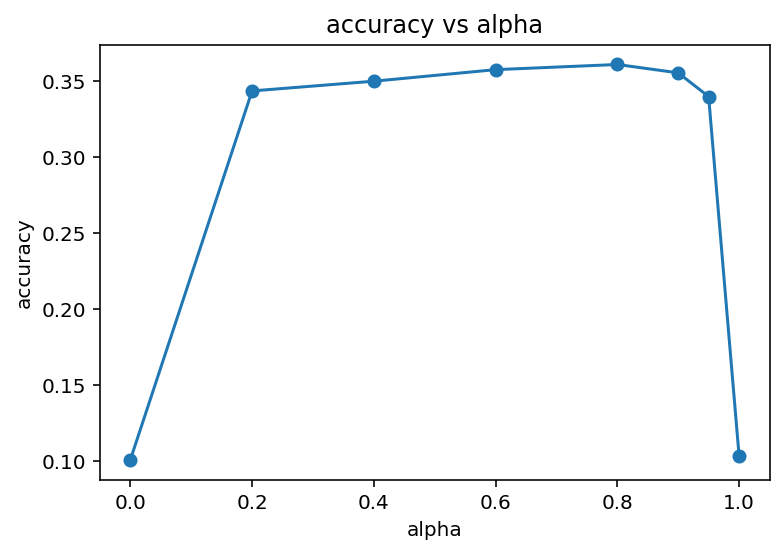

In [58]:
alpha_list = [0,.2, .4, .6, .8, .9, .95, 1]
accuracy_for_each_alpha_list = []
for alph in alpha_list:
    unlabel_data_labels = labelPropagation_new(affinity_matrix, Mat_Label, Mat_Unlabel1, labels, alpha=alph)
    corrects = 0
    for i in range(len(unlabel_data_labels)):
        if unlabel_data_labels[i] == rest_label1[i]:
            corrects +=1
    print("Accuracy for {} is {}".format(alph, corrects/10000))
    accuracy_for_each_alpha_list.append(corrects/10000)
plt.plot(alpha_list, accuracy_for_each_alpha_list, marker = 'o')
plt.title("accuracy vs alpha")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.show()

In [ ]:
2+3

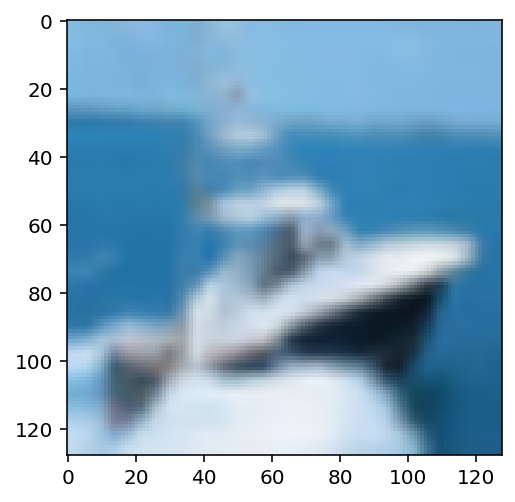

In [26]:
for b in trainloader:
    data, label = b
    break
# data = data.numpy()
# data = data[1].transpose((1,2,0))
data = data.numpy().transpose((0,2,3,1))
data = data[8]
img_resized = cv2.resize(data, (128,128))
plt.imshow(img_resized)

In [27]:
hog_feature, img_hog = feature.hog(img_resized, orientations=9, pixels_per_cell=(32,32),
               cells_per_block=(3, 3), transform_sqrt=True, block_norm="L1", visualize=True)

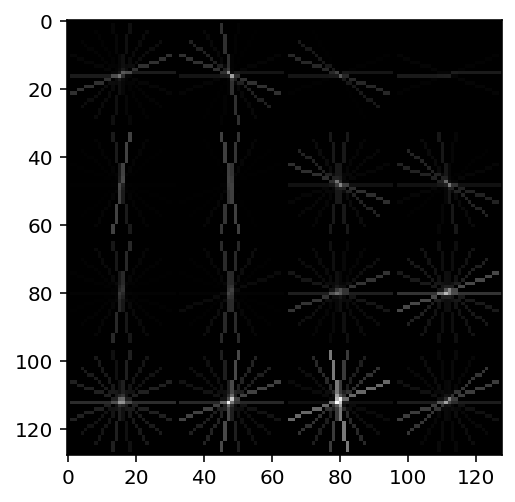

In [15]:
plt.imshow(img_hog, cmap = 'gray')

In [28]:
hog_feature.shape

(324,)

In [69]:
sift_detector = SIFT(data)

In [42]:
len(sift_detector.get_features())

4

In [49]:
sift_detector.get_features()[0].shape

(4, 128)

In [53]:
kp_pyrs = sift_detector.kp_pyr

In [57]:
kp_pyrs[0][0]

array([19.16454818, 15.41596151,  1.1967251 , 81.0616415 ])

IndexError: too many indices for array

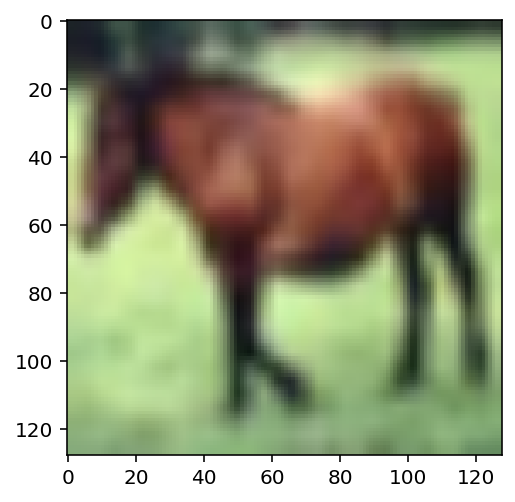

In [60]:
# _, ax = plt.subplots(1, 1)
plt.imshow(img_resized)

kps = kp_pyrs[0][0]*(2**i)
plt.scatter(kps[:,0], kps[:,1], c='b', s=2.5)

#         ax[1].imshow(ims[1])

#         kps = kp_pyrs[1][i]*(2**i)
#         ax[1].scatter(kps[:,0], kps[:,1], c='b', s=2.5)

#         ax[2].imshow(ims[2])

#         kps = kp_pyrs[2][i]*(2**i)
#         ax[2].scatter(kps[:,0], kps[:,1], c='b', s=2.5)

plt.show()

In [3]:
trainset = torchvision.datasets.CIFAR10(root='/data02/Atin/CIFAR10/', train=True, download=True)

Files already downloaded and verified


In [19]:
sift_obj = SIFT(np.array(trainset[0][0]))

In [22]:
sift_obj.get_features()[0].shape

(6, 128)

In [9]:
import cv2
sift = cv2.xfeatures2d.SIFT_create()

error: OpenCV(4.1.1) /io/opencv_contrib/modules/xfeatures2d/src/sift.cpp:1207: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'


In [13]:
from skimage.color import rgb2gray

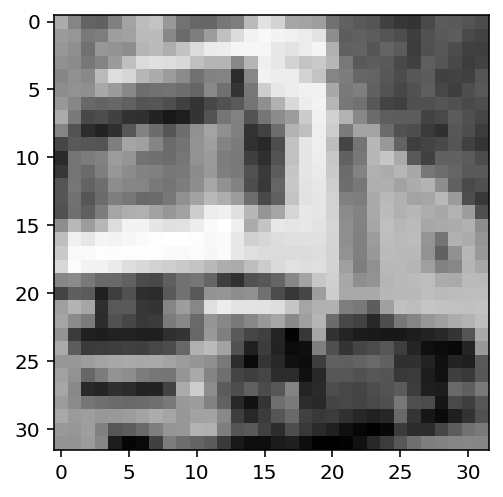

In [18]:
plt.imshow(rgb2gray(np.array(trainset[1][0])), cmap = 'gray')

In [10]:
cv2.__version__

'4.1.1'

In [13]:
import cv2 as cv2
img = np.array(trainset[0][0])

In [14]:
from skimage import feature
img_resized = cv2.resize(img, (128,128))


In [55]:
hog_feature, img_hog = feature.hog(img_resized, orientations=9, pixels_per_cell=(32,32),
               cells_per_block=(3, 3), transform_sqrt=True, block_norm="L1", visualize=True)

In [17]:
hog_feature.shape

(324,)

In [7]:
img_hog.shape

(128, 128)

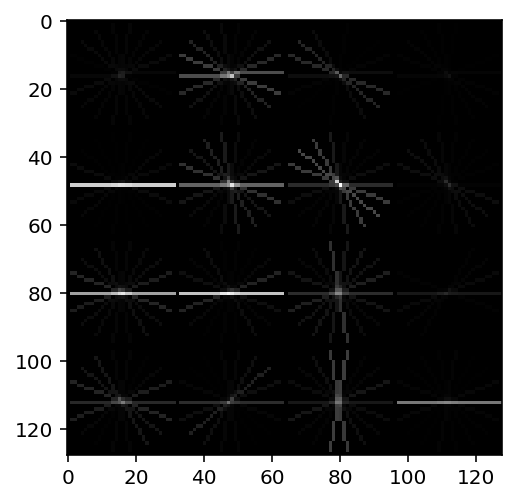

In [8]:
plt.imshow(img_hog, cmap = 'gray')

In [72]:
from pprint import pprint
from numpy import array, zeros, diag, diagflat, dot

def jacobi(A,b,N=25,x=None):
    """Solves the equation Ax=b via the Jacobi iterative method."""
    # Create an initial guess if needed                                                                                                                                                            
    if x is None:
        x = zeros(len(A[0]))

    # Create a vector of the diagonal elements of A                                                                                                                                                
    # and subtract them from A                                                                                                                                                                     
    D = diag(A)
    R = A - diagflat(D)

    # Iterate for N times                                                                                                                                                                          
    for i in range(N):
        x = (b - dot(R,x)) / D
    return x

A = array([[2.0,1.0],[5.0,7.0]])
b = array([11.0,13.0])
guess = array([1.0,1.0])

sol = jacobi(A,b,N=25,x=guess)

print("A:")
pprint(A)

print("b:")
pprint(b)

print("x:")
pprint(sol)

A:
array([[2., 1.],
       [5., 7.]])
b:
array([11., 13.])
x:
array([ 7.11110202, -3.22220342])
